In [1]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import IPython
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

%matplotlib inline

## Drawing Maps

The following function draws a map following the provided boundaries. If a dataset is provided, it also shows the dataset value associated with each area in the map. Due to problems with Chrome, we save the map with the chosen filename, instead of visualizing it on the notebook

In [31]:
def plot_map(geo_df, area_name="community", data=None, column_name="values", map_name="map.html", legend_name=" "):
    m = folium.Map(location=[41.8755616, -87.6244212], tiles='Mapbox Bright', zoom_start=10) ## This location is Chicago
    
    if data is None:
        folium.GeoJson(
            geo_df,
            name='geojson'
        ).add_to(m)
    else:
        #bins = list(data.quantile(np.linspace(0, 1, 15))) ## to use bins, gotta check fill_color
        folium.Choropleth(
            geo_data=geo_df,
            name='choropleth',
            data=data,
            columns=[area_name, column_name],
            key_on='feature.properties.{}'.format(area_name),
            fill_color='YlGnBu',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name = legend_name
            #bins=bins
        ).add_to(m)
        
    m.save("maps/" + map_name)
    return IPython.display.IFrame(src="maps/" + map_name, width=500, height=500)

## Community Areas

This dataset was provided by the city of Chicago's government. It divides the city into community areas. Throughout our project, we use these community areas as neighborhoods about which we will present and study correlations between food quality and socio-economical variables.

In [183]:
geo_df = gpd.read_file("data/chicago_boundaries_community_area.geojson")
geo_df.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [184]:
geo_df = geo_df[["community", "shape_area", "shape_len", "geometry", "area_num_1"]]
len(geo_df)

77

In [185]:
geo_df = geo_df.rename(columns={"area_num_1": "community_number"})
geo_df["community_number"] = geo_df["community_number"].astype(int)
geo_df.head()

,community,shape_area,shape_len,geometry,community_number
0,DOUGLAS,46004621.1581,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...,35
1,OAKLAND,16913961.0408,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...,36
2,FULLER PARK,19916704.8692,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...,37
3,GRAND BOULEVARD,48492503.1554,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...,38
4,KENWOOD,29071741.9283,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...,39


In [34]:
plot_map(geo_df, "community", map_name="boundary.html")

## Assigning Coordinates to Community Area

We define the following functions in order to assign a coordinate (i.e., a food inspection location) to the community area in which it is located. If a point is not inside any community area (e.g., in the boundary), we assign it to the nearest one.

In [15]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'community']

## key: key that will be used to join
def assign_community(geo_df, data, latitude="latitude", longitude="longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data, 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh['community'])]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found['community'] = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh['community'])])))
    
    columns_to_return = list(data.columns) + ["community"]
    return points_to_neigh[columns_to_return]

## Census Data

In order to normalize our results and analyze food quality prejudice by color, we also obtained information of the latest census conducted in Chicago.

In [16]:
census = pd.read_csv("data/census.csv", header=1)
census.head()

,Community,Community Number,Total Population,Age 0‐2,Age 3‐4,Age 5,Age 6‐12,Families with a child under age 6,Percent Hispanic,Percent Non‐ Hispanic Black,Percent Non‐ Hispanic White,Percent Non‐ Hispanic Asian,Percent Non‐ Hispanic Other or Multiple Races,Children 0‐5,Children 6‐17,Children 0‐5.1,Children 6‐11,Children 0‐5.2,Children 6‐11.1,Unnamed: 19
0,Rogers Park,1.0,"53,470","2,164","1,166",616,"3,819","2,708",24%,24%,45%,5%,3%,63%,61%,29%,35%,46%,70%,NaN
1,West Ridge,2.0,"75,185","3,507","2,075","1,095","7,957","4,293",20%,13%,41%,21%,4%,55%,67%,34%,40%,54%,61%,NaN
2,Uptown,3.0,"54,001","1,647",884,370,"2,681","2,053",16%,19%,51%,11%,3%,72%,61%,24%,32%,40%,70%,NaN
3,Lincoln Square,4.0,"46,881","2,163",902,324,"2,380","2,380",18%,6%,62%,10%,4%,59%,72%,14%,21%,27%,31%,NaN
4,North Center,5.0,"35,406","2,043","1,076",636,"2,873","2,468",11%,9%,73%,4%,3%,73%,77%,5%,7%,8%,15%,NaN


In [17]:
columns_to_keep = ["Community", "Total Population", "Percent Hispanic", "Percent Non‐ Hispanic Black",
                   "Percent Non‐ Hispanic White", "Percent Non‐ Hispanic Asian",
                   "Percent Non‐ Hispanic Other or Multiple Races"]
census = census[columns_to_keep]
## Renaming
census.columns = ["community", "population", "hispanic", "black", "white", "asian", "other"]
census = census.drop(census.tail(1).index)

In [18]:
races = ["hispanic", "black", "white", "asian", "other"]
census[races] = census[races].apply(lambda x: x.str.replace("%", "").astype("int32"), axis=0)
census["population"] = census["population"].str.replace(",", "").astype("int32")
census["community"] = census["community"].str.upper()
census.head()

,community,population,hispanic,black,white,asian,other
0,ROGERS PARK,53470,24,24,45,5,3
1,WEST RIDGE,75185,20,13,41,21,4
2,UPTOWN,54001,16,19,51,11,3
3,LINCOLN SQUARE,46881,18,6,62,10,4
4,NORTH CENTER,35406,11,9,73,4,3


In [19]:
census.loc[census['community'] == "O'HARE", 'community'] = 'OHARE'

In [20]:
## Check if the two dataframe indeed have the same community areas
set(geo_df["community"]) == set(census["community"])

True

## Food Inspections in Chicago

The main dataset in our project contains information about food inspections in the city of Chicago from 2010 to the present. We use the results of food inspections as a proxy of food quality in a certain community.

We drop inspections from our dataset if:
* The inspection does not indicate a pass or a failure, since we cannot evaluate the food quality without this information.
* The inspection does not assign a risk to a inspections/establishment, since we cannot evaluate the food quality without this information.
* The inspection does not have a location (i.e., latitude and longitude) because we cannot assign it to a community.

In [21]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,2216009.0,Daycare Above and Under 2 Years,Risk 1 (High),1300 W 99TH ST,CHICAGO,IL,60643.0,...,Pass,NaN,41.714168,-87.655291,"{'longitude': '41.7141680989703', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,CHICAGO,IL,60647.0,...,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
2,2320328,LAS ASADAS MEXICAN GRILL,LAS ASADAS MEXICAN GRILL,2583309.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Out of Business,NaN,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
3,2320319,LA PALAPITA,LA PALAPITA,2694702.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2320228,47TH ST CANTINA,47TH ST CANTINA,2678250.0,Liquor,Risk 3 (Low),4311 W 47TH ST,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.807662,-87.731480,"{'longitude': '41.80766199360051', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [22]:
columns_to_keep = ["Inspection ID", "DBA Name", "AKA Name", "Risk", "Results", "Latitude", "Longitude", "Violations", "Inspection Date"]
inspections = inspections[columns_to_keep]
## Renaming
inspections.columns = ["inspection_id", "dba_name", "aka_name", "risk", "results", "latitude", "longitude", "violations", "date"]

In [23]:
## Mapping to redifine the risk

def map_risk(x_):
    x = str(x_)
    if "High" in x:
        return 1
    elif "Medium" in x:
        return 2
    elif "Low" in x:
        return 3
    else:
        return x
    
## Mapping to retrieve the value of the violation
    
def map_n_violations(x_):
    x = str(x_)
    return x.split(".")[0]
    
## Reformating the dataframe
inspections["date"] = pd.to_datetime(inspections["date"])
inspections = inspections.dropna(subset=["latitude", "longitude"])
inspections = inspections[inspections["results"].isin(["Pass", "Pass w/ Conditions", "Fail"])]
inspections["risk"] = inspections["risk"].apply(map_risk)
inspections = inspections[inspections["risk"].isin([1, 2, 3])]
inspections["risk"] = inspections["risk"].astype("int16")
inspections["n_violations"] = inspections["violations"].fillna(0).apply(map_n_violations)
inspections["n_violations"] = inspections["n_violations"].astype("int32")
inspections.head()

,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,1,Pass,41.714168,-87.655291,NaN,2019-10-23,0
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,1,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,23
3,2320319,LA PALAPITA,LA PALAPITA,1,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,47
4,2320228,47TH ST CANTINA,47TH ST CANTINA,3,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3
5,2320261,CRAZY BIRD,CRAZY BIRD,1,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,16


In [24]:
## Assigning the community areas
inspections_community = assign_community(geo_df, inspections, verbose=True)
inspections_community.head()

There are 2665 points without an exact neighborhood
There are 0 points without an exact neighborhood


C:\Users\Gabriel\Miniconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations,geometry,community
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,1,Pass,41.714168,-87.655291,NaN,2019-10-23,0,POINT (-87.65529116028439 41.7141680989703),WASHINGTON HEIGHTS
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,1,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,23,POINT (-87.6822028354253 41.9135877900482),WEST TOWN
3,2320319,LA PALAPITA,LA PALAPITA,1,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,47,POINT (-87.72003743037237 41.80802515275297),ARCHER HEIGHTS
4,2320228,47TH ST CANTINA,47TH ST CANTINA,3,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3,POINT (-87.7314802731113 41.8076619936005),ARCHER HEIGHTS
5,2320261,CRAZY BIRD,CRAZY BIRD,1,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,16,POINT (-87.65705497652716 41.89119348444125),WEST TOWN


The following maps show:
1. The log-number of inspections in each community per 100 citizens.
2. Rate of inspection failure by community.
3. A community's average risk of an establishment adversely affecting the public’s health in the range [0, 3], with three indicating a higher risk.
4. The average number of food inspection violations in each community per 10000 citizens.
5. The number of inspections in each community normalized by number of establishments in our dataset.
6. The number of violations in each community normalized by number of establishments in our dataset.

In [25]:
population_community = census[["community", "population"]].set_index("community")["population"]
n_establishments = inspections_community.groupby("community")["dba_name"].nunique()

In [45]:
## 1) Number of inspections per 100 citizens
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
n_inspections_per_capita = n_inspections.div(population_community) * 100
plot_map(geo_df, data=np.log(n_inspections_per_capita), map_name="n_inspections.html", legend_name="Log-number of inspections per 100 citizens")

In [37]:
## 2) Rate of failure
neigh_results = inspections_community.groupby(["community", "results"]).count()["inspection_id"].rename("values")
percentage_results = (neigh_results.div(n_inspections) * 100).reset_index()
failure_community = percentage_results[percentage_results["results"]=="Fail"]
failure_community = failure_community.drop("results", axis="columns").set_index("community")["values"]
plot_map(geo_df, data=failure_community, map_name="rate_failure.html", legend_name='Rate of failure (%)')

In [46]:
## 3) Average risk
average_risk = inspections_community.groupby("community").mean()["risk"].rename("values")
plot_map(geo_df, data=average_risk, map_name="average_risk.html", legend_name='Average risk (between 1 and 3)')

In [47]:
## 4) Number of violations per capita (10000)
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
average_violations_per_capita = average_violations.div(population_community) * 10000
plot_map(geo_df, data=np.log(average_violations_per_capita), map_name="average_n_violations.html", legend_name='Log-average number of food violations per 10000 citizens')

In [48]:
## 5) # inspections / # establishments
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
norm_n_inspections = n_inspections.div(n_establishments)
plot_map(geo_df, data=norm_n_inspections, map_name="n_inspections_per_establish.html", legend_name='Number of inspections per establishment')

In [49]:
## 6) Number of violations / # establishments
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
norm_average_violations = average_violations.div(n_establishments)
plot_map(geo_df, data=np.log(norm_average_violations), map_name="average_n_violations_per_establish.html", legend_name='Log-number of food violations per establishment')

We can see through these maps that the food is indeed not of the same quality across all community areas.

## Hardship Index

The city of Chicago also makes available the economic hardship of all its community areas. The economic hardship index is a function of:

1. Unemployment (over the age of 16 years),
2. Education (over 25 years of age without a high school
diploma)
3. Per capita income level
4. Poverty (below the federal poverty level)
5. Crowded housing (housing units with more than one person
per room)
6. Dependency (population under 18 or over 64 years of age)

We will use the economic hardship index as a measurement of economic conditions of each community area in Chicago. A higher index indicates poorer conditions. For more information on the index: https://greatcities.uic.edu/wp-content/uploads/2016/07/GCI-Hardship-Index-Fact-SheetV2.pdf

In [50]:
income_df = pd.read_csv("data/Per_Capita_Income.csv")
income_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [51]:
## Renaming
income_df.columns = ['community_number','community','percentage_housing_crowded','percent_households_below_poverty','percent_aged_16+_unemployed','percent_aged_25+_without_highschool_diploma','percent_aged_under_18_or_over_64','per_capita_income','hardship_index']
income_df["community"].unique

<bound method Series.unique of 0         Rogers Park
1          West Ridge
2              Uptown
3      Lincoln Square
4        North Center
           ...       
73    Mount Greenwood
74        Morgan Park
75             O'Hare
76          Edgewater
77            CHICAGO
Name: community, Length: 78, dtype: object>

In [52]:
## Getting rid of the non relevant last row
income_df = income_df[income_df["community"] != 'CHICAGO']
## Reformating the community area names
income_df["community"] = income_df["community"].str.upper()

In [53]:
## Checking if the income dataframe has the same community areas as the geojson dataframe
set(geo_df["community"]) == set(income_df["community"])

False

In [54]:
## Displaying the differences
set(geo_df["community"]) - set(income_df["community"])

{'MONTCLARE', 'OHARE', 'WASHINGTON HEIGHTS'}

In [55]:
set(income_df["community"]) - set(geo_df["community"])

{'MONTCLAIRE', "O'HARE", 'WASHINGTON HEIGHT'}

In [56]:
## Correcting the issue 
income_df.loc[income_df['community'] == "O'HARE", 'community'] = 'OHARE'
income_df.loc[income_df['community'] == "MONTCLAIRE", 'community'] = 'MONTCLARE'
income_df.loc[income_df['community'] == "WASHINGTON HEIGHT", 'community'] = 'WASHINGTON HEIGHTS'
## Checking if the income dataframe has the same community areas
set(geo_df["community"]) == set(income_df["community"])

True

We normalize hardship into a [0, 1] range for our analysis. Since hardship is not a concept easy to understand as it is a function of many economic variables, we believe that comparing between communities will be easier after normalizing the index.

In [63]:
delta_hardship = income_df["hardship_index"].max() - income_df["hardship_index"].min()
income_df["hardship_index"] = (income_df["hardship_index"] - income_df["hardship_index"].min())/delta_hardship

In [234]:
hardship = income_df[["community", "hardship_index"]].set_index("community").rename(columns={"hardship_index": "values"})["values"]
plot_map(geo_df, data=hardship, map_name="hardship.html", legend_name='Hardship Index')

### 1) Correlation Between Race and Food Quality

Since each community areas has a dominant race, and that food quality varies from one community to another, we speculate that the food quality may vary depending on the race.

In [66]:
def plot_correlation_food_variables(food_quality_index=None, index_name="",
                                    variables_df=None, variables=None, variable_name="", method="pearson"):
    correlations = []
    for var in variables:
        var_community = variables_df[["community", var]].set_index("community")[var]
        correlations.append(var_community.corr(food_quality_index, method=method))
    plt.bar(x=variables, height=correlations)
    plt.title("Correlation between {} and {}".format(variable_name, index_name))

In [67]:
def scatter_plot(food_quality_index=None, index_name="",
                           variable_df=None, variable_name="", method="pearson"):
    plt.ylabel(index_name)
    plt.xlabel(variable_name)
    plt.scatter(variable_df, food_quality_index)

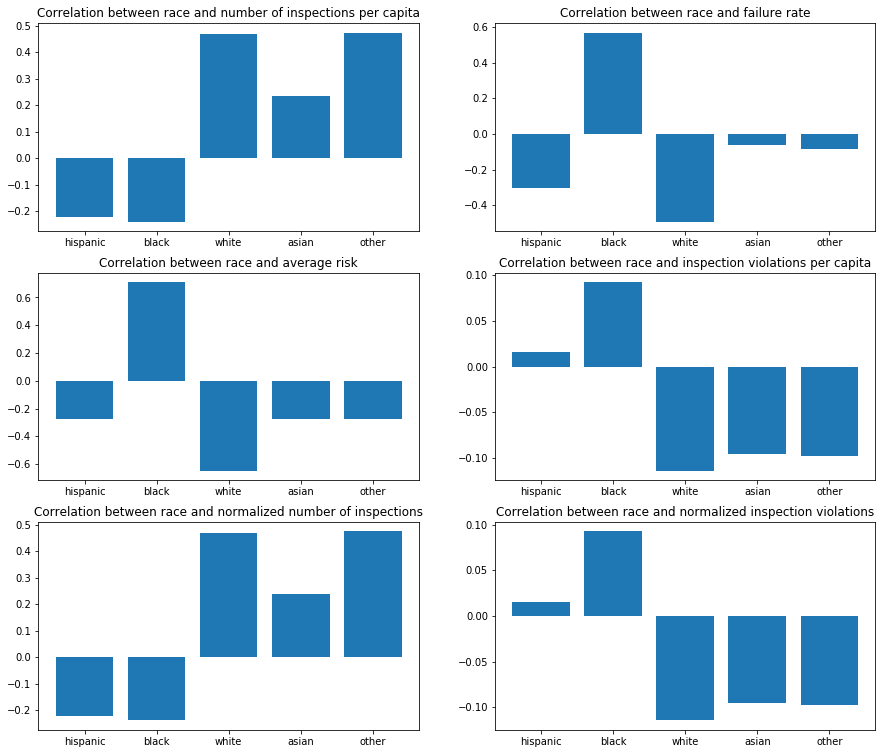

In [68]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
plot_correlation_food_variables(norm_n_inspections, index_name="number of inspections per capita",
                                variables_df=census, variables=races, variable_name="race")

## 2) Rate of failure
plt.subplot(3, 2, 2)
plot_correlation_food_variables(failure_community, index_name="failure rate",
                                variables_df=census, variables=races, variable_name="race")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
plot_correlation_food_variables(average_risk, index_name="average risk",
                                variables_df=census, variables=races, variable_name="race")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
plot_correlation_food_variables(norm_average_violations, index_name="inspection violations per capita",
                                variables_df=census, variables=races, variable_name="race")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
plot_correlation_food_variables(norm_n_inspections, index_name="normalized number of inspections",
                                variables_df=census, variables=races, variable_name="race")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
plot_correlation_food_variables(norm_average_violations, index_name="normalized inspection violations",
                                variables_df=census, variables=races, variable_name="race")

Apparently, the black population lives in community areas with lower quality of food, a higher number of inspection violations, a lower number of inspections as well as a higher risk.

On the other hand, it is the complete opposite for the white population: they have higher quality of food, a lower number of inspection violations, a higher number of inspections and a lower value of risk.

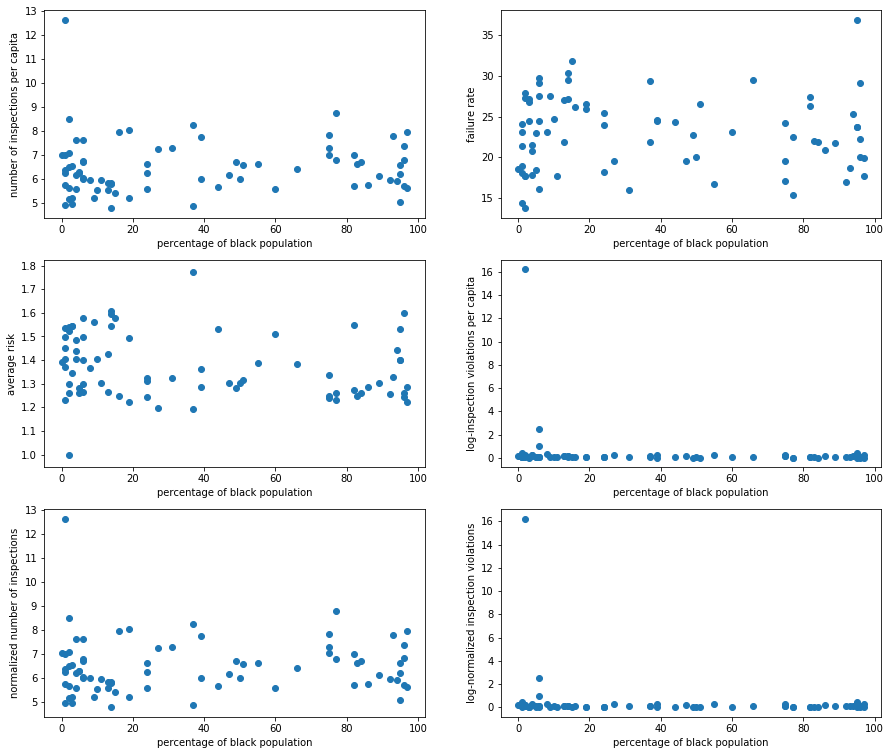

In [77]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita

plt.subplot(3, 2, 1)
scatter_plot(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot(failure_community, index_name="failure rate",
                                variable_df=census["black"], variable_name="percentage of black population")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
scatter_plot(average_risk, index_name="average risk",
                                variable_df=census["black"], variable_name="percentage of black population")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot(norm_average_violations, index_name="log-inspection violations per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=census["black"], variable_name="percentage of black population")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot(norm_average_violations, index_name="log-normalized inspection violations",
                                variable_df=census["black"], variable_name="percentage of black population")

Unfortunately the scatterplots don't show any correlation. We'll then proceed with a significance test of our correlation index.

In [79]:
def pearson_correlation_and_pvalue(x,y):
    corr, pval = pearsonr(x,y)
    print('\nThe correlation between the variables is:', corr)
    print('The p-value of this correlation is:', pval)
    
pearson_correlation_and_pvalue(norm_n_inspections, census['black'])
pearson_correlation_and_pvalue(failure_community, census['black'])
pearson_correlation_and_pvalue(average_risk, census['black'])
pearson_correlation_and_pvalue(norm_average_violations, census['black'])
pearson_correlation_and_pvalue(norm_n_inspections, census['black'])
pearson_correlation_and_pvalue(norm_average_violations, census['black'])


The correlation between the variables is: 0.06268847785396406
The p-value of this correlation is: 0.5880769475379856

The correlation between the variables is: -0.02130681694271938
The p-value of this correlation is: 0.8540689063083394

The correlation between the variables is: -0.2050441008276864
The p-value of this correlation is: 0.07363339643252736

The correlation between the variables is: -0.1359695748866785
The p-value of this correlation is: 0.2383591064174578

The correlation between the variables is: 0.06268847785396406
The p-value of this correlation is: 0.5880769475379856

The correlation between the variables is: -0.1359695748866785
The p-value of this correlation is: 0.2383591064174578


Note that no correlation is indeed significant. Therefore, we posit that the black population of Chicago do not suffer from a lower quality of food.

In [80]:
pearson_correlation_and_pvalue(norm_n_inspections, census['white'])
pearson_correlation_and_pvalue(failure_community, census['white'])
pearson_correlation_and_pvalue(average_risk, census['white'])
pearson_correlation_and_pvalue(norm_average_violations, census['white'])
pearson_correlation_and_pvalue(norm_n_inspections, census['white'])
pearson_correlation_and_pvalue(norm_average_violations, census['white'])


The correlation between the variables is: -0.10645470574051476
The p-value of this correlation is: 0.3568002856579901

The correlation between the variables is: 0.013842217750634097
The p-value of this correlation is: 0.9048919636881911

The correlation between the variables is: 0.19700993577552048
The p-value of this correlation is: 0.08591452796477711

The correlation between the variables is: 0.1351962983049814
The p-value of this correlation is: 0.24106461004802837

The correlation between the variables is: -0.10645470574051476
The p-value of this correlation is: 0.3568002856579901

The correlation between the variables is: 0.1351962983049814
The p-value of this correlation is: 0.24106461004802837


The white population of Chicago also do not have any negative or positive correlation to food quality.

### 2) Correlation Between Hardship and Food Quality

The higher the hardship index is, the lower are the educational and income level.
We then speculate that the higher the educational and income level, the higher is the food quality.

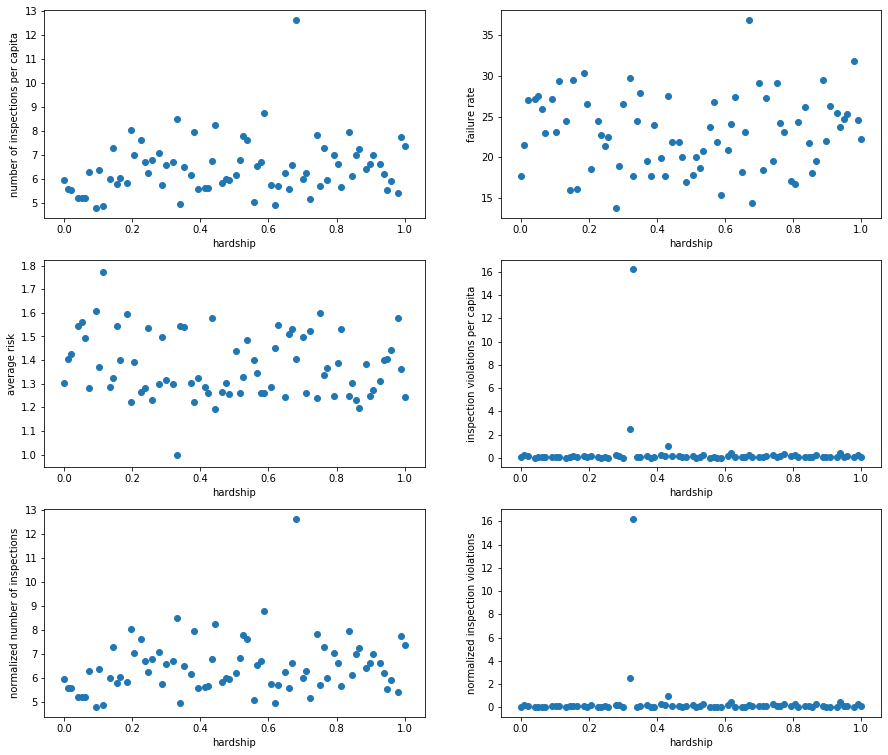

In [82]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
scatter_plot(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=hardship, variable_name="hardship")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot(failure_community, index_name="failure rate",
                                variable_df=hardship, variable_name="hardship")

## 3) Average risk
plt.subplot(3, 2, 3)
scatter_plot(average_risk, index_name="average risk",
                                variable_df=hardship, variable_name="hardship")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot(norm_average_violations, index_name="inspection violations per capita",
                                variable_df=hardship, variable_name="hardship")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=hardship, variable_name="hardship")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=hardship, variable_name="hardship")

Unfortunately, these scatter plots seem to prove the initial assumption wrong: there doesn't seem to be any correlation between the hardship and the food quality.

In [83]:
pearson_correlation_and_pvalue(norm_n_inspections,  hardship)
pearson_correlation_and_pvalue(failure_community, hardship)
pearson_correlation_and_pvalue(average_risk, hardship)
pearson_correlation_and_pvalue(norm_average_violations, hardship)
pearson_correlation_and_pvalue(norm_n_inspections, hardship)
pearson_correlation_and_pvalue(norm_average_violations, hardship)


The correlation between the variables is: 0.19413458033201705
The p-value of this correlation is: 0.09068465604724686

The correlation between the variables is: 0.0227341825900151
The p-value of this correlation is: 0.8444113485786257

The correlation between the variables is: -0.14930707667689647
The p-value of this correlation is: 0.19497103231168783

The correlation between the variables is: -0.06677113633103438
The p-value of this correlation is: 0.5639560702506623

The correlation between the variables is: 0.19413458033201705
The p-value of this correlation is: 0.09068465604724686

The correlation between the variables is: -0.06677113633103438
The p-value of this correlation is: 0.5639560702506623


The lack of correlation is also found when observing the p-values of the pearson correlation.

# Crime Dataset Investigation

In [138]:
crime_df = pd.read_csv('data/Crimes_2001-2019.csv')
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


Limit the data to the period 2010-2019

In [139]:
crime_df = crime_df.loc[crime_df.Year>2009]
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [140]:
crime_df['Primary Type'].unique()

array(['CRIM SEXUAL ASSAULT', 'BURGLARY', 'THEFT',
       'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'CRIMINAL DAMAGE', 'OTHER OFFENSE', 'SEX OFFENSE', 'ASSAULT',
       'NARCOTICS', 'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
       'MOTOR VEHICLE THEFT', 'BATTERY', 'OBSCENITY',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'NON-CRIMINAL',
       'PUBLIC PEACE VIOLATION', 'INTIMIDATION', 'ARSON', 'STALKING',
       'INTERFERENCE WITH PUBLIC OFFICER',
       'CONCEALED CARRY LICENSE VIOLATION', 'KIDNAPPING',
       'HUMAN TRAFFICKING', 'HOMICIDE', 'GAMBLING', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

Some types of violation can be excluded for some resons:
- Liquor law violation is not an index of a dangerous neighborhood
- Non-criminal actions are used to code police calls that are not crimes
- Concealed carry license violations are assigned to a vehicle in movement so we can not connect the place where is found to its original neighborhood

In [141]:
crime_df = crime_df[~crime_df['Primary Type'].isin(['LIQUOR LAW VIOLATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)'])]
crime_df.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,...,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
10,11227586,JB147613,02/10/2017 12:00:00 PM,089XX S COTTAGE GROVE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,8.0,44.0,14,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [142]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [143]:
crime_df['Location']

1                                    NaN
2                                    NaN
3                                    NaN
4                                    NaN
5                                    NaN
                       ...              
7001558    (41.862830429, -87.717040084)
7001559    (41.864278228, -87.659660218)
7001560    (41.864278357, -87.659682244)
7001561                              NaN
7001562                              NaN
Name: Location, Length: 2920357, dtype: object

Note that community area 0 is not a real community area. It is an outlier which (we hypothesize) indicates crimes in areas around Chicago. Also, there is no community area with number 0 in the GeoJson file provided by the city of Chicago.

We will finally assign the community area where the crime was commited by comparing the *community_number* column of the GeoJson.

In [174]:
crime_df["Community Area"].value_counts()

25.0    184194
8.0     108276
43.0     97658
29.0     92724
23.0     92591
         ...  
55.0      6443
74.0      6378
12.0      5254
47.0      4186
9.0       2833
Name: Community Area, Length: 77, dtype: int64

In [145]:
crime_df.drop(['ID', 'Case Number', 'Domestic', 'Beat', 'Ward', 'FBI Code', 'Updated On', 'Block', 'Description', 'Location Description', 'Arrest', 'IUCR', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
crime_df = crime_df[crime_df["Community Area"] != 0.0]

In [221]:
crime_df.head()

,Date,Primary Type,District,Community Area,Year,Latitude,Longitude
1,10/08/2017 03:00:00 AM,CRIM SEXUAL ASSAULT,22.0,73.0,2017,41.696869,-87.717748
2,03/28/2017 02:00:00 PM,BURGLARY,8.0,70.0,2017,41.743389,-87.656161
3,09/09/2017 08:17:00 PM,THEFT,3.0,42.0,2017,41.738992,-87.555059
4,08/26/2017 10:00:00 AM,CRIM SEXUAL ASSAULT,1.0,32.0,2017,41.837838,-87.713361
5,02/10/2013 12:00:00 AM,CRIM SEXUAL ASSAULT,7.0,69.0,2013,41.747997,-87.707143


In [188]:
# crime_df["community"] = crime_df["Community Area"].apply(lambda x: geo_df[geo_df["community_number"] == x]["community"])
# crime_df.head()

In [ ]:
# crime_df.to_csv("data/edited_crime.csv")

In [222]:
crimes_by_community = crime_df.groupby('Community Area').count()['Date'].rename('values')
crimes_by_community.index = geo_df.sort_values("community_number")["community"]
crimes_by_community

community
ROGERS PARK           42347
WEST RIDGE            36848
UPTOWN                40085
LINCOLN SQUARE        20435
NORTH CENTER          15734
                      ...  
WASHINGTON HEIGHTS    35086
MOUNT GREENWOOD        6378
MORGAN PARK           23328
OHARE                 17850
EDGEWATER             27439
Name: values, Length: 77, dtype: int64

In [229]:
criminality = crimes_by_community.div(population_community)
criminality

community
ROGERS PARK           0.791977
WEST RIDGE            0.490098
UPTOWN                0.742301
LINCOLN SQUARE        0.435891
NORTH CENTER          0.444388
                        ...   
WASHINGTON HEIGHTS    1.250303
MOUNT GREENWOOD       0.377888
MORGAN PARK           0.976067
OHARE                 1.746234
EDGEWATER             0.485337
Length: 77, dtype: float64

In [235]:
plot_map(geo_df, 'community', data=criminality, map_name='crime.html', legend_name="Crimes per capita")

The map shows 2 areas composed by more communities that have more criminality, there is some overlapping between these areas and the parts where there are more food violations

In [231]:
pearson_correlation_and_pvalue(norm_n_inspections, criminality)
pearson_correlation_and_pvalue(failure_community, criminality)
pearson_correlation_and_pvalue(average_risk, criminality)
pearson_correlation_and_pvalue(norm_average_violations, criminality)
pearson_correlation_and_pvalue(norm_n_inspections, criminality)
pearson_correlation_and_pvalue(norm_average_violations, criminality)


The correlation between the variables is: 0.07224889914960352
The p-value of this correlation is: 0.5323460624471417

The correlation between the variables is: 0.04826662587260089
The p-value of this correlation is: 0.6767855789109088

The correlation between the variables is: -0.1518491658641965
The p-value of this correlation is: 0.18739113604147886

The correlation between the variables is: -0.07823765131110633
The p-value of this correlation is: 0.49882401344295063

The correlation between the variables is: 0.07224889914960352
The p-value of this correlation is: 0.5323460624471417

The correlation between the variables is: -0.07823765131110633
The p-value of this correlation is: 0.49882401344295063


Our results show that there is no correlation between criminality and food quality. We also plot the scatter plots for visualization.

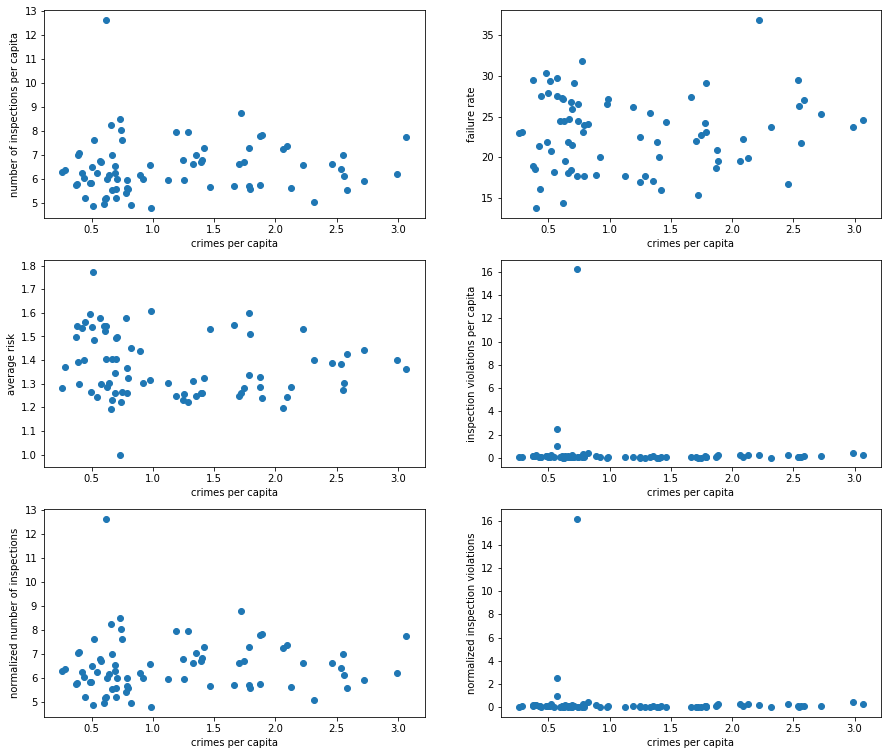

In [233]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
scatter_plot(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=criminality, variable_name="crimes per capita")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot(failure_community, index_name="failure rate",
                                variable_df=criminality, variable_name="crimes per capita")

## 3) Average risk
plt.subplot(3, 2, 3)
scatter_plot(average_risk, index_name="average risk",
                                variable_df=criminality, variable_name="crimes per capita")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot(norm_average_violations, index_name="inspection violations per capita",
                                variable_df=criminality, variable_name="crimes per capita")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=criminality, variable_name="crimes per capita")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=criminality, variable_name="crimes per capita")

In [232]:
pearson_correlation_and_pvalue(criminality, census["black"])


The correlation between the variables is: 0.746269497806502
The p-value of this correlation is: 6.742705001374599e-15


Even though it is not the focus of our project, we found that there is a high correlation between black population and criminality.